In [50]:
from huggingface_hub import hf_hub_download
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "Elriggs/pythia-70m-deduped"

# The layer around which we want to interpret by looking at the last layer
layer_focus = 1
assert layer_focus > 0

In [51]:
def load_autoencoder(layer: int):
	# No clue what this means
	# seedMaybe = 63
	seedMaybe = 31
	ae_download_location_main = hf_hub_download(repo_id=model_id, filename=f"tied_residual_l{layer_focus}_r6/_{seedMaybe}/learned_dicts.pt")
	all_autoencoders = torch.load(ae_download_location_main)
	all_l1s = [hyperparams["l1_alpha"] for autoencoder, hyperparams in all_autoencoders]
	# TODO: choose best one???
	print(all_l1s)
	auto_num = 5
	autoencoder, hyperparams = all_autoencoders[auto_num]
	# You want a hyperparam around 1e-3. Higher is less features/datapoint (at the cost of reconstruction error); lower is more features/datapoint (at the cost of polysemanticity)
	autoencoder.to_device(device)
	print(hyperparams)
	return autoencoder, hyperparams

autoencoder_main, hyperparams_main = load_autoencoder(layer_focus)
autoencoder_prior, hyperparams_prior = load_autoencoder(layer_focus - 1)

[0.0, 9.999999747378752e-05, 0.00019306977628730237, 0.000372759357560426, 0.0007196856895461679, 0.0013894954463467002, 0.0026826958637684584, 0.005179474595934153, 0.009999999776482582]
{'dict_size': 3072, 'l1_alpha': 0.0013894954463467002}
[0.0, 9.999999747378752e-05, 0.00019306977628730237, 0.000372759357560426, 0.0007196856895461679, 0.0013894954463467002, 0.0026826958637684584, 0.005179474595934153, 0.009999999776482582]
{'dict_size': 3072, 'l1_alpha': 0.0013894954463467002}


In [52]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import numpy as np

In [53]:
from transformer_lens import HookedTransformer
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"

model = HookedTransformer.from_pretrained(model_name, device=device)

def get_cache_name_neurons(layer: int):
    if setting == "residual":
        cache_name = f"blocks.{layer}.hook_resid_post"
        neurons = model.cfg.d_model
    elif setting == "mlp":
        cache_name = f"blocks.{layer}.mlp.hook_post"
        neurons = model.cfg.d_mlp
    elif setting == "attention":
        cache_name = f"blocks.{layer}.hook_attn_out"
        neurons = model.cfg.d_model
    elif setting == "mlp_out":
        cache_name = f"blocks.{layer}.hook_mlp_out"
        neurons = model.cfg.d_model
    else:
        raise NotImplementedError
    return cache_name, neurons

cache_name, neurons  = get_cache_name_neurons(layer_focus)
cache_name_prior, _  = get_cache_name_neurons(layer_focus - 1)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [54]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
# dataset_name = "NeelNanda/pile-10k"
# dataset_name = "JeanKaddour/minipile"
token_amount= 40
#TODO: change train[:1000] to train if you want whole dataset
# 100_000 datasets
# I think that we want to use the full 1_000_000 at some point...
dataset = load_dataset(dataset_name, split="train[:10000]").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)
# TODO: we can maybe make this faster for the larger dataset?

Found cached dataset parquet (/home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9862 [00:00<?, ? examples/s]

# Get Dictionary Activations

In [55]:
# TODO: in chunks...
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from datasets import DatasetDict
from tqdm.auto import tqdm
from einops import rearrange
import math

# MAX_CHUNK_SIZE = 1_000

# TODO: move to a separate file or something
def get_activations(autoencoder, f_name):
    num_features, d_model = autoencoder.encoder.shape
    datapoints = dataset.num_rows
    dictionary_activations_final = np.memmap(f'{f_name}.mymemmap', dtype='float32', mode='w+', shape=(datapoints * token_amount, num_features))
    # neuron_activations = torch.zeros((datapoints*token_amount, d_model))
    neuron_activations = np.memmap(f'neur{f_name}.mymemmap', dtype='float32', mode='w+', shape=(datapoints * token_amount, d_model))
    batch_size = 32
    # dictionary_activations = np.zeros((datapoints*token_amount, num_features))
    smaller_auto_encoder = autoencoder
    smaller_auto_encoder.to_device(device)

    # print("Creating data dict")
    # d = DatasetDict(Dataset(dataset[ind_low:ind_max]))
    # print("Got data dict")
    # with torch.no_grad(), d.formatted_as("pt"):
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            # print(batch)
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
            batched_dictionary_activations = smaller_auto_encoder.encode(batched_neuron_activations)
            dictionary_activations_final[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu().numpy()
    del neuron_activations
        # dictionary_activations_final[ind_low:ind_max] = dictionary_activations
        # chunks.append(dictionary_activations)
    return dictionary_activations_final

dict_activations_main = get_activations(autoencoder_main, f"layer_{layer_focus}")
dict_activations_prior = get_activations(autoencoder_prior, f"layer_{layer_focus - 1}")
# TODO: I think that we may want to save this to disk for the future


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

#### Find the the minimum size necessary for an activation to be considered a word

In [56]:
nonzeroind = np.nonzero(dict_activations_main)
nonzero_sort = np.sort(dict_activations_main[np.nonzero(dict_activations_main)])

In [57]:
print(nonzero_sort[:200].tolist())

[8.940696716308594e-08, 1.1920928955078125e-07, 1.1920928955078125e-07, 1.1920928955078125e-07, 1.1920928955078125e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 4.76837158203125e-07, 5.960464477539062e-07, 5.960464477539062e-07, 6.705522537231445e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.82310962677002e-07, 8.344650268554688e-07, 9.5367431640625e-07, 1.0132789611816406e-06, 1.0728836059570312e-06, 1.0728836059570312e-06, 1.1920928955078125e-06, 1.1920928955078125e-06, 1.1920928955078125e-06, 1.1920928955078125e-06, 1.1920928955078125e-06, 1.19209289550781

## Build the 2-depth Concept Lattice
<!-- TODO: general depth -->

In [58]:
datapoints = dataset.num_rows
num_features_prior, _ = autoencoder_prior.encoder.shape
num_features_main, _ = autoencoder_main.encoder.shape

graph = np.memmap(f'graph_{layer_focus}.mymemmap', dtype='float32', mode='w+', shape=(num_features_main, num_features_prior))

for i in range(num_features_main):
		graph[i,:] = np.zeros(num_features_prior)

In [59]:
eps = 0.001

for i in range(datapoints):
	d_prior = dict_activations_prior[i]
	d_main = dict_activations_main[i]
	for main_feat in range(num_features_main):
		if d_main[main_feat] > eps:
			graph[main_feat] += d_prior

In [60]:
# We have this many "dead" features (i.e. never activated by this dataset)
(graph.sum(axis=1) == 0).sum()

15

In [61]:
# TODO: hmmm. The `graph` is data-set dependent so we want to renormalize
graph = graph / graph.sum(axis=1, keepdims=True)

/tmp/ipykernel_87108/1174004706.py:2: RuntimeWarning: invalid value encountered in divide
  graph = graph / graph.sum(axis=1, keepdims=True)


In [62]:
epsCutoff = 0.005

graphCutoff = np.nan_to_num((graph >= epsCutoff) * graph)

Feature has 14 connections


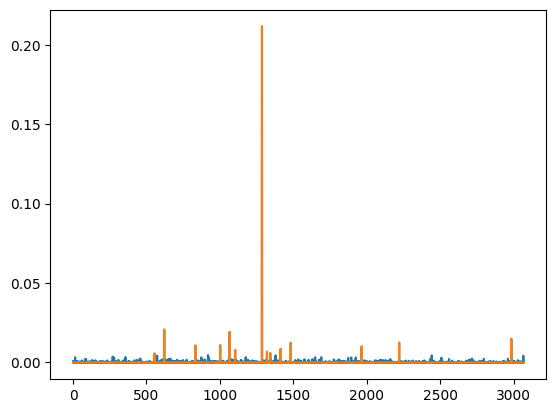

In [63]:
# Check how "sparse" the graph is
import matplotlib.pyplot as plt

# 10 has **a bunch** of connections
# feature = 10

feature = 1966

max_features = np.argsort(graphCutoff[feature])[::-1]
# print(max_features[:10].tolist(), graphCutoff[feature][max_features][:10].tolist())
print(f"Feature has {graphCutoff[feature].nonzero()[0].shape[-1]} connections")

# print(graph[feature], dict_activations_prior.sum())
plt.plot(graph[feature])
plt.plot(graphCutoff[feature])

In [64]:
for i in range(num_features_main):
	if graphCutoff[i].sum() == 0:
		if graph[i].sum() > 0:
			print(f"Feature {i} has no connections in cutoff but {graph[i].sum()} connections in non-cutoff")
		else:
			print(f"Feature {i} has no connections at all!")

Feature 39 has no connections at all!
Feature 125 has no connections at all!
Feature 658 has no connections at all!
Feature 877 has no connections at all!
Feature 921 has no connections at all!
Feature 952 has no connections at all!
Feature 1015 has no connections at all!
Feature 1270 has no connections at all!
Feature 1421 has no connections at all!
Feature 1847 has no connections at all!
Feature 1932 has no connections at all!
Feature 1975 has no connections at all!
Feature 2498 has no connections at all!
Feature 2534 has no connections at all!
Feature 2900 has no connections at all!


## Some Graphing

In [65]:
INCLUDE_WEIGHTS = True
PRIOR_ON_RIGHT = False
GRAPH_SIZE_MAIN = 30

In [66]:
main_feats = np.random.choice(num_features_main, GRAPH_SIZE_MAIN, replace=False)

[2755 1926  518  929  631  926 2636 2563 1735 1450  810  730 2743 2876
 2678 2803  511 2333  841 1357 2305  960 2703  766 2698 2696 1305 1085
 2382 2298]


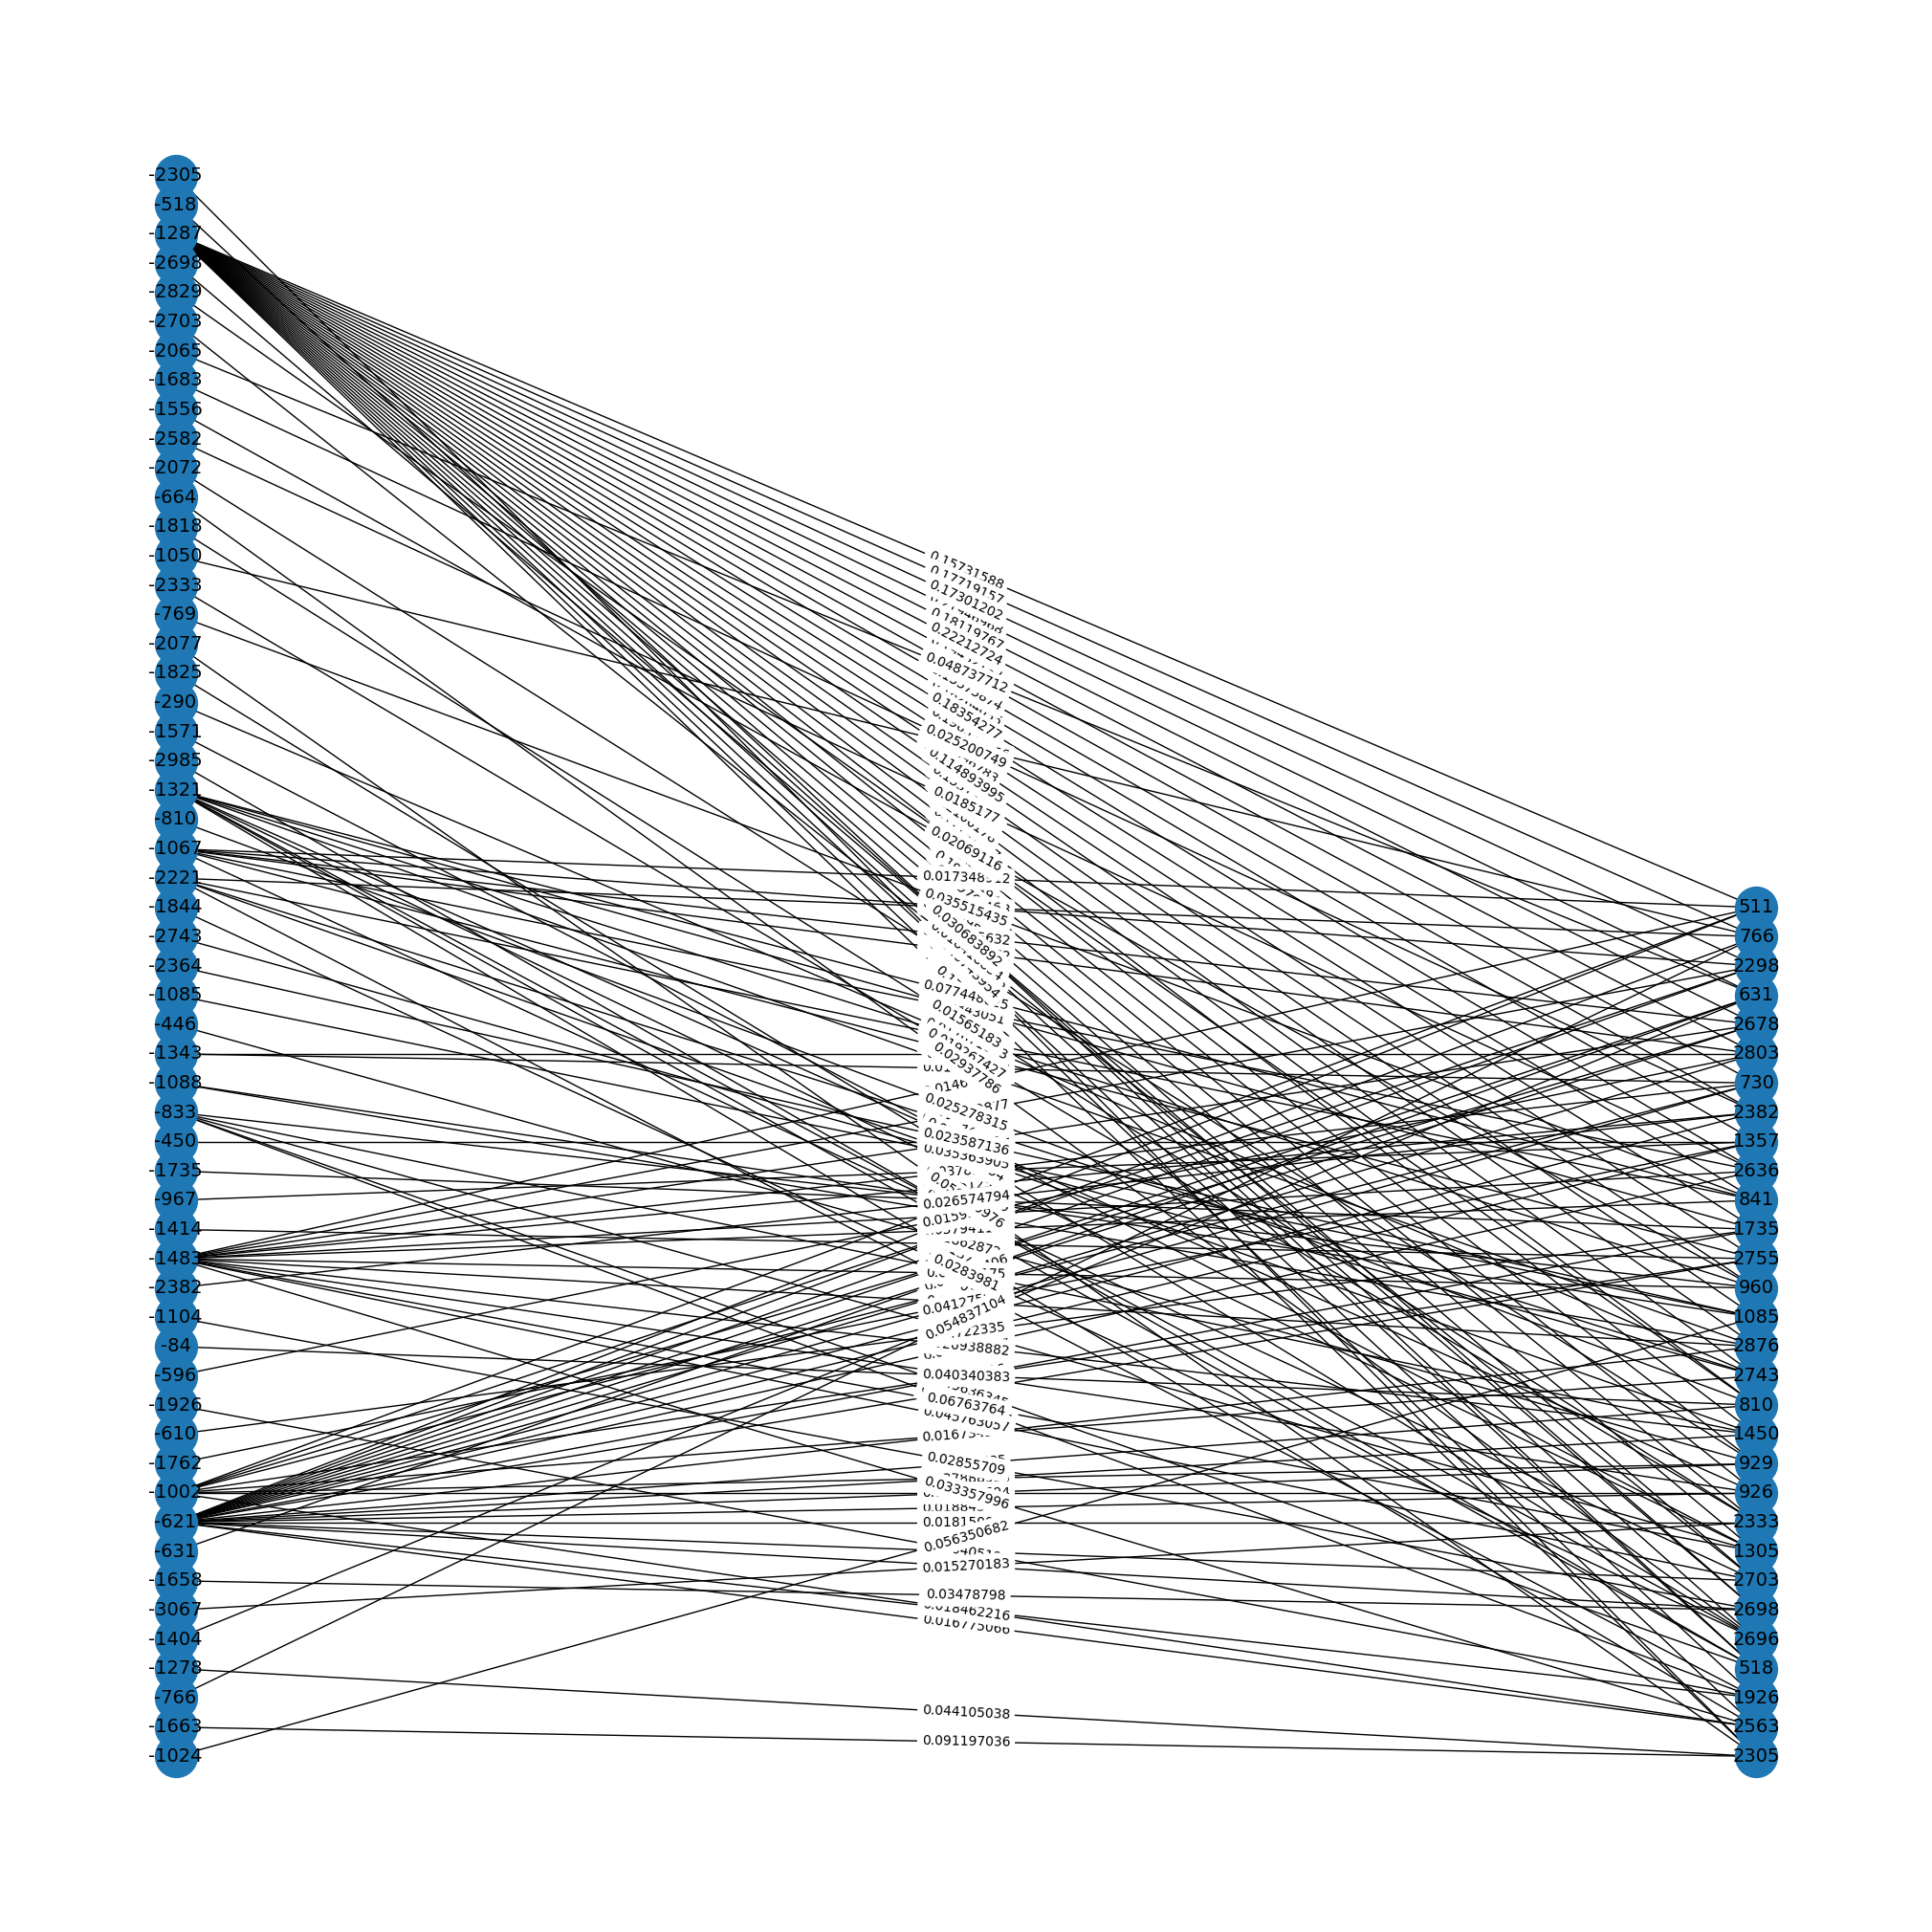

In [67]:
import matplotlib.pyplot as plt
import networkx as nx

# main_feats = np.random.choice(np.nonzero(graphCutoff.sum(axis=1))[0], GRAPH_SIZE_MAIN, replace=False)
print(main_feats)
prior_feats = np.nonzero(graphCutoff[main_feats])[1]

randomGraphProjection = graphCutoff[main_feats][:,prior_feats]


# Create a new bipartite graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
# nodes_u = set((prior_feats * -1).tolist())  # Set of nodes V
# nodes_v = main_feats.tolist() # Set of nodes U
# B.add_nodes_from(nodes_u, bipartite=0)  # Label one set of nodes 0
# B.add_nodes_from(nodes_v, bipartite=1)  # Label the other set of nodes 1

edges = []

for main in main_feats:
	has_edge = False
	# nonzerod = graphCutoff[main].nonzero()[0]
	D_NEIGHBORS = 5
	args = np.argsort(graphCutoff[main])[::-1][:5]
	# print(args, graphCutoff[main][args])
	for prior in args:
		if graphCutoff[main][prior] > 0:
			if INCLUDE_WEIGHTS:
				edges.append((prior * -1, main, graphCutoff[main][prior]))
			else:
				edges.append((prior * -1, main))
			has_edge = True
	# for j in range(prior_feats.shape[-1]):
	# 	if randomGraphProjection[i,j] > 0:
	# 		print("Adding edge")
	# 		edges.append((prior_feats[j], main_feats[i], randomGraphProjection[i,j]))
	# 		has_edge = True
	if not has_edge:
		print("NO EDGE FOR FEATURE", main)
# Add edges with weights
if INCLUDE_WEIGHTS:
	B.add_weighted_edges_from(edges)
else:
	B.add_edges_from(edges)

# Separate by group
l, r = nx.bipartite.sets(B)

if PRIOR_ON_RIGHT:
	# Reverse the sets so that the LHS is the prior
	l, r = r, l
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

# Draw the graph
plt.figure(1, figsize=(20, 20))
nx.draw(B, pos, with_labels=True, node_size=1_000, font_size=14)

# Draw edge labels
edge_labels = nx.get_edge_attributes(B, 'weight')

if INCLUDE_WEIGHTS:
	nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)
else:
	pass
plt.show()


## Utils

In [81]:
from circuitsvis.activations import text_neuron_activations
import torch
import numpy as np
from einops import rearrange

# Get the activations for the best dict features
def get_feature_datapoints_with_idx(feature_index, dictionary_activations, tokenizer, token_amount, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = np.argsort(best_feature_activations)[:k]
        # found_indices = np.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = np.min(best_feature_activations)
        max_value = np.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = np.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        # TODO: hmm
        # np bucketize?
        # bins = torch.bucketize(best_feature_activations, bin_boundaries)
        bins = np.digitize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in np.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = np.array(np.nonzero(bins == bin_idx)).squeeze(axis=0)
            # print(bin_indices.shape)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = np.flip(np.array(sampled_indices), axis=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    num_datapoints = int(dictionary_activations.shape[0]/token_amount)
    datapoint_indices =[np.unravel_index(i, (num_datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, found_indices

## Some interpretability with GPT-4 and **context**

In [104]:
# From https://github.com/openai/automated-interpretability/blob/main/neuron-explainer/neuron_explainer/explanations/explainer.py
from interp_utils import get_neuron_activation


ROLE = "We're studying neurons in a neural network. Each neuron looks for some particular" + \
"thing in a short document. Look at the parts of the document the neuron activates for " + \
"and summarize in a single sentence what the neuron is looking for. Don't list " + \
"examples of words.\n\nThe activation format is token<tab>activation. Activation " + \
"values range from 0 to 10. A neuron finding what it's looking for is represented by a " + \
"non-zero activation value. The higher the activation value, the stronger the match."
 

def get_samples_and_act_for_feature(feature_idx: int, n_samples=10):
	text_list, _, _, _, _ = get_feature_datapoints_with_idx(feature_idx, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="uniform", k=n_samples)
	split_texts = []
	activations = []
	max_act = -1
	min_act = 1e10
	for t in text_list:
		split_text = model.to_str_tokens(t, prepend_bos=False)
		token = model.to_tokens(t, prepend_bos=False)
		_a = get_neuron_activation(token, feature_idx, model, autoencoder_prior, layer_focus - 1, setting="dictionary_basis")
		acts = np.array(_a)
		if acts.sum() > 0:
			# Rescale to between 0 and 10
			# activations.append((acts - acts.min()) / ((acts.max() - acts.min()) / 10))
			if acts.max() > max_act:
				max_act = acts.max()
			if acts.min() < min_act:
				min_act = acts.min()

			activations.append(acts)
			split_texts.append(split_text)
	
	for i in range(len(activations)):
		activations[i] = (activations[i] - min_act) / ((max_act - min_act) / 10)
		activations[i] = activations[i].tolist()
	return split_texts, activations



# TODO: integrate with auto-inter?
def create_prompt_for_prior(feature_idx: int, n_samples=10):
	# TODO: Adjust k!!
	texts, acts = get_samples_and_act_for_feature(feature_idx, n_samples=n_samples)	
	entries = []
	for t, a in zip(texts, acts):
		e = []
		# print("TEXT:", t)
		# print("ACTIVATION:", a)
		for tok, act in zip(t, a):
			e.append(f"{tok}\t{act}")
		joined = '\n'.join(e)
		entries.append(f"<start>\n{joined}\n<end>")
	joined = "\n".join(entries)
	return f"""{ROLE}

Neuron {feature_idx}
Activations:
{joined}
"""

s = create_prompt_for_prior(10)
print(s)

We're studying neurons in a neural network. Each neuron looks for some particularthing in a short document. Look at the parts of the document the neuron activates for and summarize in a single sentence what the neuron is looking for. Don't list examples of words.

The activation format is token<tab>activation. Activation values range from 0 to 10. A neuron finding what it's looking for is represented by a non-zero activation value. The higher the activation value, the stronger the match.

Neuron 10
Activations:
<start>
)/	6.488736786902229
<end>
<start>
)/	6.488743647786229
18	0.5805868714411845
<end>
<start>
)/	6.488743647786229
18	0.5805868714411845
52	0.0
<end>
<start>
03	0.0
)?	9.194156585097902
<end>
<start>
+	0.0
 4	0.0
*	0.0
t	0.0
)	5.509692070661959
 -	3.146727294011606
<end>
<start>
R	0.0
ut	0.36265003359689135
hen	0.0
ium	0.0
(	0.0
sal	0.0
en	0.0
)-	0.0
catal	0.0
yzed	0.0
 aerobic	0.907225840147406
 oxidative	0.0
 des	0.0
ym	0.0
met	0.0
rization	0.0
<end>
<start>
Sem	3.760583

In [ ]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(model_name='gpt-4')
llm(

# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [68]:
dict_activations_prior.shape

(394480, 3072)

In [70]:
from interp_utils import *

In [80]:
feature_idx = 1167
text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="uniform")
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus - 1)

[0.0, 0.0, 0.0, 0.0, 0.0, 2.057697296142578, 0.0]

Type:            TiedSAE
String form:     <autoencoders.learned_dict.TiedSAE object at 0x7f784585e950>
File:            ~/code/research/ai/play_around/sparse_coding/autoencoders/learned_dict.py
Docstring:       <no docstring>
Class docstring:
Helper class that provides a standard way to create an ABC using
inheritance.

In [72]:
feature_idx = 2031

text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_main, model.tokenizer, token_amount, dataset, setting="uniform", k=100)
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus)